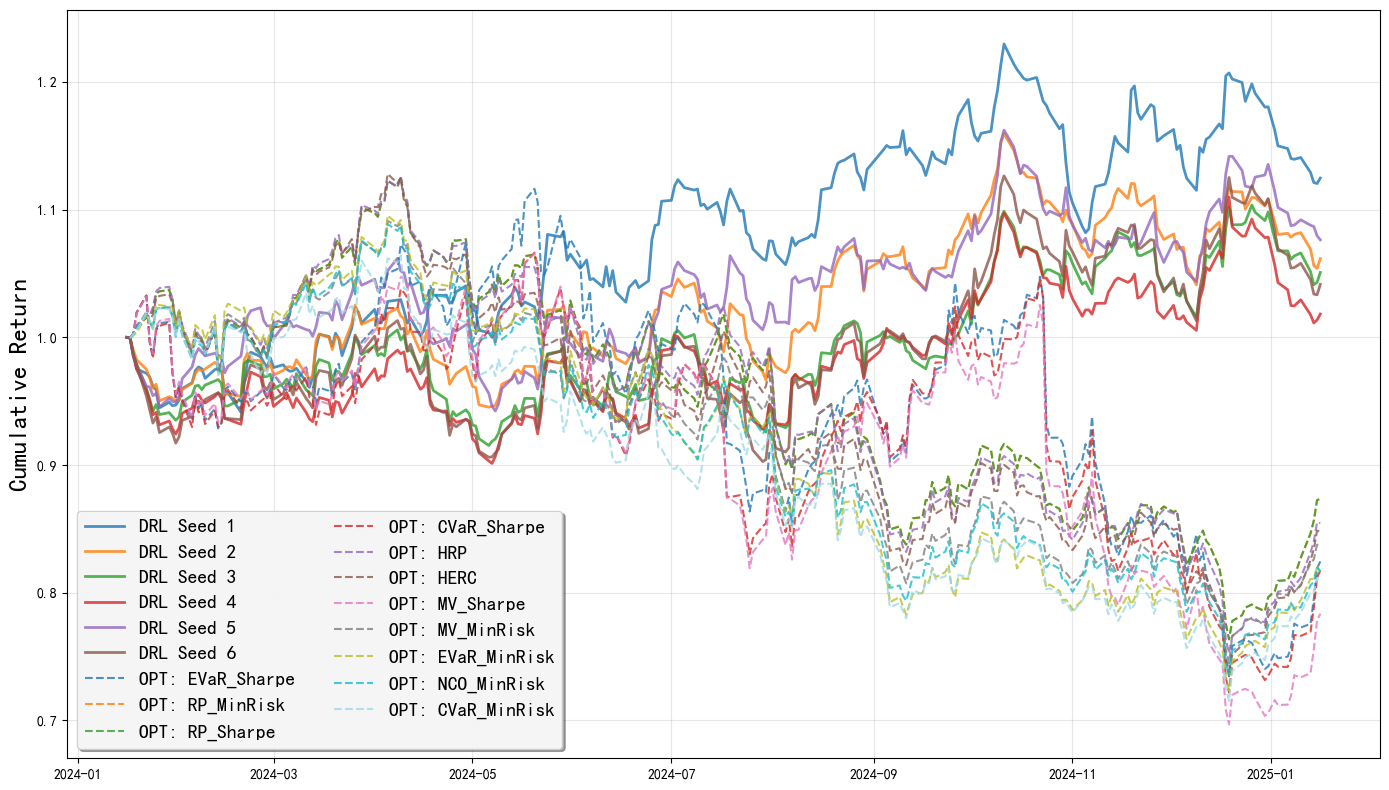

Combined plot saved as SVG and PDF formats.
DRL Seeds plotted: 6
Optimization models plotted: 11


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# Set Chinese font support
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ========== Part 1: Load DRL Seed Data ==========
# File names for different seeds
seed_file_names = [
    'summary_allseeds_and_calculations/SP500_results/df_PPO_vgg1_Tanh_maxSharpe_arbitrage_seed1.csv',
    'summary_allseeds_and_calculations/SP500_results/df_PPO_vgg1_Tanh_maxSharpe_arbitrage_seed2.csv', 
    'summary_allseeds_and_calculations/SP500_results/df_PPO_vgg1_Tanh_maxSharpe_arbitrage_seed3.csv',
    'summary_allseeds_and_calculations/SP500_results/df_PPO_vgg1_Tanh_maxSharpe_arbitrage_seed4.csv',
    'summary_allseeds_and_calculations/SP500_results/df_PPO_vgg1_Tanh_maxSharpe_arbitrage_seed5.csv',
    'summary_allseeds_and_calculations/SP500_results/df_PPO_vgg1_Tanh_maxSharpe_arbitrage_seed6.csv'
]

# Colors for seed lines
seed_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Store seed data
seed_data = []
seed_dates = None

# Load each seed file
for i, file_name in enumerate(seed_file_names):
    df_seed = pd.read_csv(file_name)
    df_seed['date'] = pd.to_datetime(df_seed['date'])
    df_seed.set_index('date', inplace=True)
    seed_data.append((df_seed, f'DRL Seed {i+1}'))
    if seed_dates is None:
        seed_dates = df_seed.index

# ========== Part 2: Load Optimization Model Data ==========
# Load optimization model data
opt_dfs = []
for infile in glob.glob('computational_economics-longshortOPT/SP500/StocksOPT/data/temp/forStocks/values/*.csv'):
    df_opt = pd.read_csv(infile, index_col='date', parse_dates=True)
    name = os.path.splitext(os.path.basename(infile))[0]
    df_opt.name = name
    opt_dfs.append(df_opt)

# Sort and concatenate optimization data
opt_dfs.sort(key=lambda x: x.name, reverse=False)
df_opt_combined = pd.concat(opt_dfs, axis=1, keys=[df.name for df in opt_dfs], names=['Pair', 'Price'])
df_opt_combined = df_opt_combined.droplevel('Pair', axis=1)
df_opt_combined.dropna(inplace=True)

# Calculate returns and Sharpe ratios for optimization models
R_opt = np.log(df_opt_combined / df_opt_combined.shift())
R_opt = pd.DataFrame(R_opt)
R_opt.dropna(inplace=True)

# Add Sharpe ratios and sort
df_opt_combined.loc['Sharpe'] = R_opt.apply(lambda x: (np.sqrt(252) * np.mean(x)) / (np.std(x)))
df_opt_sorted = df_opt_combined.sort_values(by='Sharpe', axis=1, ascending=False)
df_opt_sorted = df_opt_sorted.iloc[:-1, :]  # Remove Sharpe row

# Take top 12 optimization models
df_opt_top12 = df_opt_sorted.iloc[:, :12]

# ========== Part 3: Create Combined Plot ==========
fig_combined = plt.figure(figsize=(14, 8))
ax = fig_combined.add_subplot(1, 1, 1)

# Plot DRL seeds as solid lines
for i, (df_seed, label) in enumerate(seed_data):
    ax.plot(df_seed.index, df_seed['portfolio_value'], 
            color=seed_colors[i], 
            linewidth=2,
            label=label,
            alpha=0.8,
            linestyle='-')  # Solid lines for seeds

# Plot optimization models as dashed lines
opt_colors = plt.cm.tab20(np.linspace(0, 1, len(df_opt_top12.columns)))
for i, col in enumerate(df_opt_top12.columns):
    ax.plot(df_opt_top12.index, df_opt_top12[col], 
            color=opt_colors[i],
            linewidth=1.5,
            label=f'OPT: {col}',
            alpha=0.8,
            linestyle='--')  # Dashed lines for optimization models

# Set plot properties
# ax.set_title('S&P500 Portfolio Performance: Long-Short DRL vs Other Optimization Models', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Cumulative Return', fontsize=18)
ax.grid(True, alpha=0.3)

# Place legend in the lower left corner of the plot
ax.legend(loc='lower left',
          fontsize=14,
          ncol=2,
          framealpha=0.9,
          fancybox=True,
          shadow=True)

# Format x-axis
plt.xticks(rotation=0)

# Show plot
plt.tight_layout()
plt.show()

# ========== Part 4: Save Plots ==========
# Create directory if it doesn't exist
os.makedirs('./img', exist_ok=True)

# Save as SVG
fig_combined.savefig('./img/combined_DRL_seeds_vs_optimization_models(SP500).svg', 
                    bbox_inches='tight',
                    dpi=300,
                    format='svg')

# Save as PDF
fig_combined.savefig('./img/combined_DRL_seeds_vs_optimization_models(SP500).pdf', 
                    bbox_inches='tight', 
                    dpi=300,
                    format='pdf')

print("Combined plot saved as SVG and PDF formats.")
print(f"DRL Seeds plotted: {len(seed_data)}")
print(f"Optimization models plotted: {len(df_opt_top12.columns)}")